<a href="https://colab.research.google.com/github/lovepreetmultani/Anti-Money-Laundering/blob/main/No_hyperp_xgboost_Fraud_Detection_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Data load

In [1]:
!pip install explainerdashboard
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.7
    Uninstalling Werkzeug-2.3.7:
      Successfully uninstalled Werkzeug-2.3.7


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
!pip install torch torchvision
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=021cfa34293f8425ab430572e1cea4fa4548e2fb942059c955cce127b52d6338
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [3]:
!pip install xgboost
import xgboost as xgb


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
from datetime import datetime as dt
from sklearn.feature_selection import  f_classif, SelectKBest
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score

In [6]:
import torch

# Check if CUDA (GPU support for PyTorch) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Using CPU')

Using CPU


In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
fraud=pd.read_csv("drive/My Drive/Dissertation/Data-2-small.csv")

In [9]:
fraud.head()

,tx_fraud,tx_amount,s_pagerank,s_label,s_min_send_tx,s_min_receieve_tx,s_max_send_tx,s_max_recieve_tx,s_avg_send_tx,s_avg_recieve_tx,...,r_label,r_min_send_tx,r_min_receieve_tx,r_max_send_tx,r_max_recieve_tx,r_avg_send_tx,r_avg_recieve_tx,r_cnt_recieve_tx,r_cnt_send_tx,r_timestamp
0,True,2661.05,1.64276,52429084,90.98,45.89,2661.05,2956.72,174.60600,314.35879,...,52429264,91.04,46.12,109.53,2661.05,99.75712,851.45423,26,52,1509580800
1,True,2661.05,0.89618,37749079,90.19,45.72,2661.05,2956.72,207.55542,437.18238,...,52429264,91.04,46.12,109.53,2661.05,99.75712,851.45423,26,52,1509321600
2,True,2844.06,0.70773,34603485,90.30,48.52,2844.06,54.41,159.08872,52.09875,...,47186571,90.69,45.27,2559.65,2844.06,238.81746,200.33864,103,71,1499731200
3,True,2523.37,2.55504,49283515,91.41,45.03,2523.37,2803.73,270.59857,139.48263,...,34603040,90.58,45.65,109.96,2662.20,99.81943,781.37258,31,35,1485043200
4,True,2745.06,1.35612,55574890,90.66,45.34,2745.06,2718.14,245.75222,320.09300,...,57672098,90.34,45.72,2470.55,2745.06,314.67291,291.58139,79,55,1513987200


In [10]:
fraud.columns

Index(['tx_fraud', 'tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
       's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
       's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
       's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
       'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
       'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
       'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp'],
      dtype='object')

([<matplotlib.patches.Wedge at 0x7973f11d1d50>,
 [Text(-1.0648862397143757, 0.27571234369715397, 'Not Fraud'),
  Text(1.0648862526214007, -0.2757122938462312, 'Fraud')],
 [Text(-0.5808470398442048, 0.15038855110753852, '91.94%'),
  Text(0.5808470468844003, -0.1503885239161261, '8.06%')])

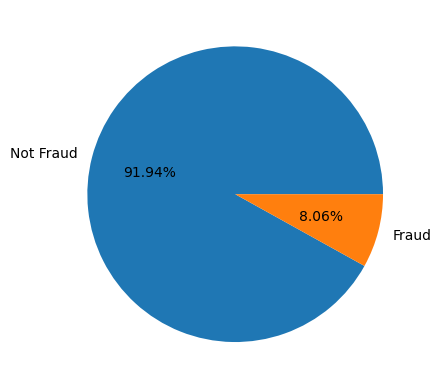

In [11]:
plt.pie(fraud['tx_fraud'].value_counts(),  labels=['Not Fraud', 'Fraud'],autopct='%.2f%%')

## Data balacing

In [14]:
from imblearn.over_sampling import SMOTE

# ... Your existing imports and code for reading data ...

# Features and labels before SMOTE
features = fraud[['tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
                 's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                 's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                 's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
                 'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
                 'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
                 'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp']]
labels = fraud['tx_fraud']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)

# Replace your original 'fraud' DataFrame with the resampled data
fraud_resampled = features_resampled.copy()
fraud_resampled['tx_fraud'] = labels_resampled

In [15]:
fraud_resampled['tx_fraud'].value_counts()

True     9200
False    9200
Name: tx_fraud, dtype: int64

([<matplotlib.patches.Wedge at 0x7973edb8c790>,
 [Text(6.735557395310444e-17, 1.1, 'Not Fraud'),
  Text(-2.0206672185931328e-16, -1.1, 'Fraud')],
 [Text(3.6739403974420595e-17, 0.6, '50.00%'),
  Text(-1.1021821192326178e-16, -0.6, '50.00%')])

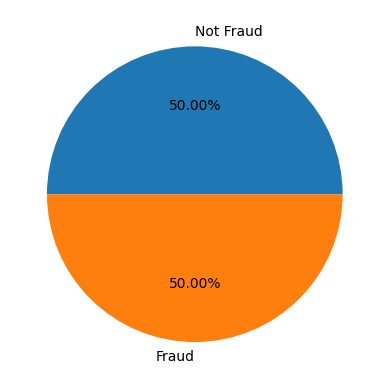

In [16]:
plt.pie(fraud_resampled['tx_fraud'].value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%.2f%%')

## Data preprocessing

In [17]:
import torch
from torch_geometric.data import Data


# Step 1: Map unique accounts to unique integer IDs
unique_accounts = pd.concat([fraud_resampled['s_label'], fraud_resampled['r_label']]).drop_duplicates()
account_to_id = {account: i for i, account in enumerate(unique_accounts)}

# Step 2: Create the edge_index tensor
source_node_indices = fraud_resampled['s_label'].map(account_to_id).values
target_node_indices = fraud_resampled['r_label'].map(account_to_id).values

edge_index = torch.tensor(
    [
        source_node_indices,  # Source nodes
        target_node_indices   # Target nodes
    ],
    dtype=torch.long
)

<ipython-input-17-170449250967>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edge_index = torch.tensor(


In [19]:
numerical_features = fraud.select_dtypes(include=['int', 'float'])

<ipython-input-20-bfe9ce8870e8>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 800x550 with 0 Axes>

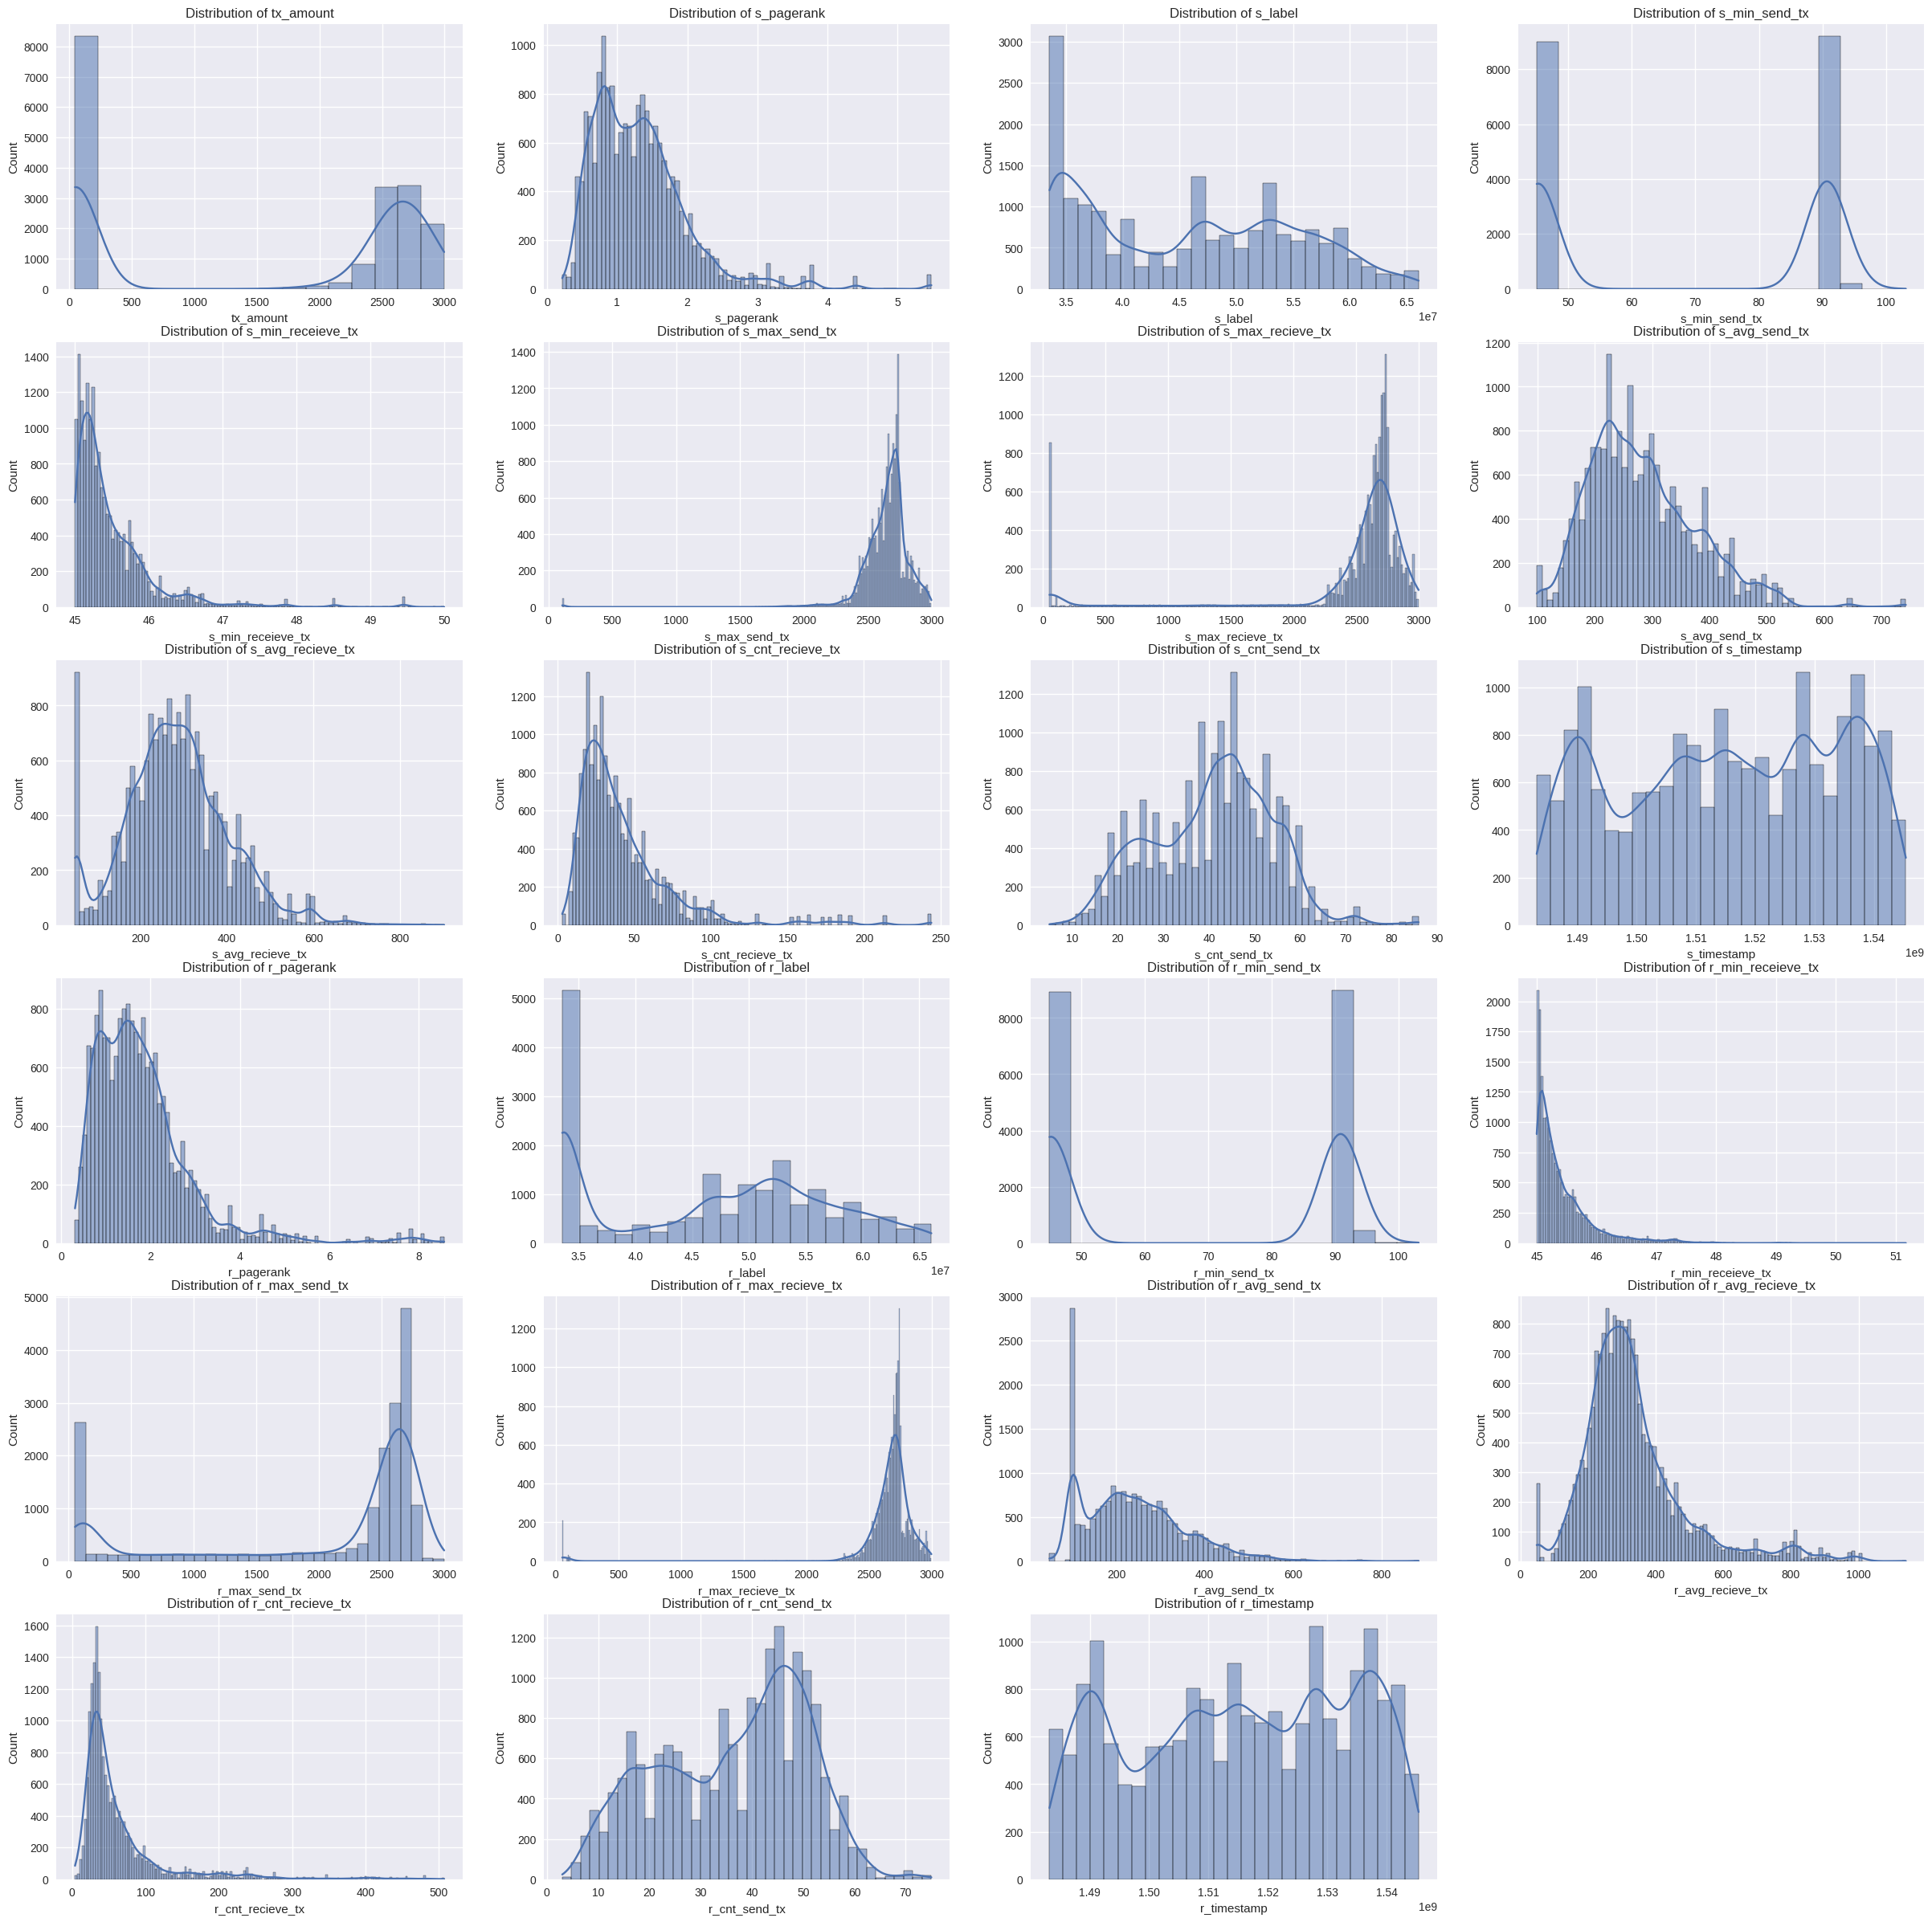

In [20]:
plt.style.use("seaborn")
plt.subplots_adjust(top=0.9,hspace=6,wspace = 3)
plt.figure(figsize=(30,30))
plt.subplot(6,4,1)
i=1
for feature in fraud_resampled.columns:
    if feature  in numerical_features :
        plt.subplot(6,4,i)
        sns.histplot(data=fraud_resampled, x=feature, kde=True)
        plt.title("Distribution of {}".format(feature))
        i+=1

In [21]:
from sklearn.preprocessing import StandardScaler

# Extract the features from the resampled data
features_to_scale = ['tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
                     's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                     's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                     's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
                     'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
                     'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
                     'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp']

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the features
fraud_data_scaled = fraud_resampled.copy()
fraud_data_scaled[features_to_scale] = scaler.fit_transform(fraud_resampled[features_to_scale])


# Use the scaled features in the resampled dataset
fraud_resampled_scaled = fraud_data_scaled.copy()

# Node features for the sender and receiver
sender_features_scaled = torch.tensor(fraud_resampled_scaled[['s_pagerank', 's_label', 's_min_send_tx',
                                  's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                                  's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                                  's_cnt_send_tx', 's_timestamp']].values, dtype=torch.float)

receiver_features_scaled = torch.tensor(fraud_resampled_scaled[['r_pagerank', 'r_label', 'r_min_send_tx',
                                    'r_min_receieve_tx', 'r_max_send_tx', 'r_max_recieve_tx',
                                    'r_avg_send_tx', 'r_avg_recieve_tx', 'r_cnt_recieve_tx',
                                    'r_cnt_send_tx', 'r_timestamp']].values, dtype=torch.float)

# Combining the sender and receiver features
x_scaled = torch.cat([sender_features_scaled, receiver_features_scaled], dim=1)

# Edge features
edge_attr_scaled = torch.tensor(fraud_resampled_scaled[['tx_amount']].values, dtype=torch.float)

# Create a PyTorch Geometric data object with scaled features
data_scaled = Data(x=x_scaled, edge_index=edge_index, edge_attr=edge_attr_scaled)


<ipython-input-22-6f39e854ede8>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 800x550 with 0 Axes>

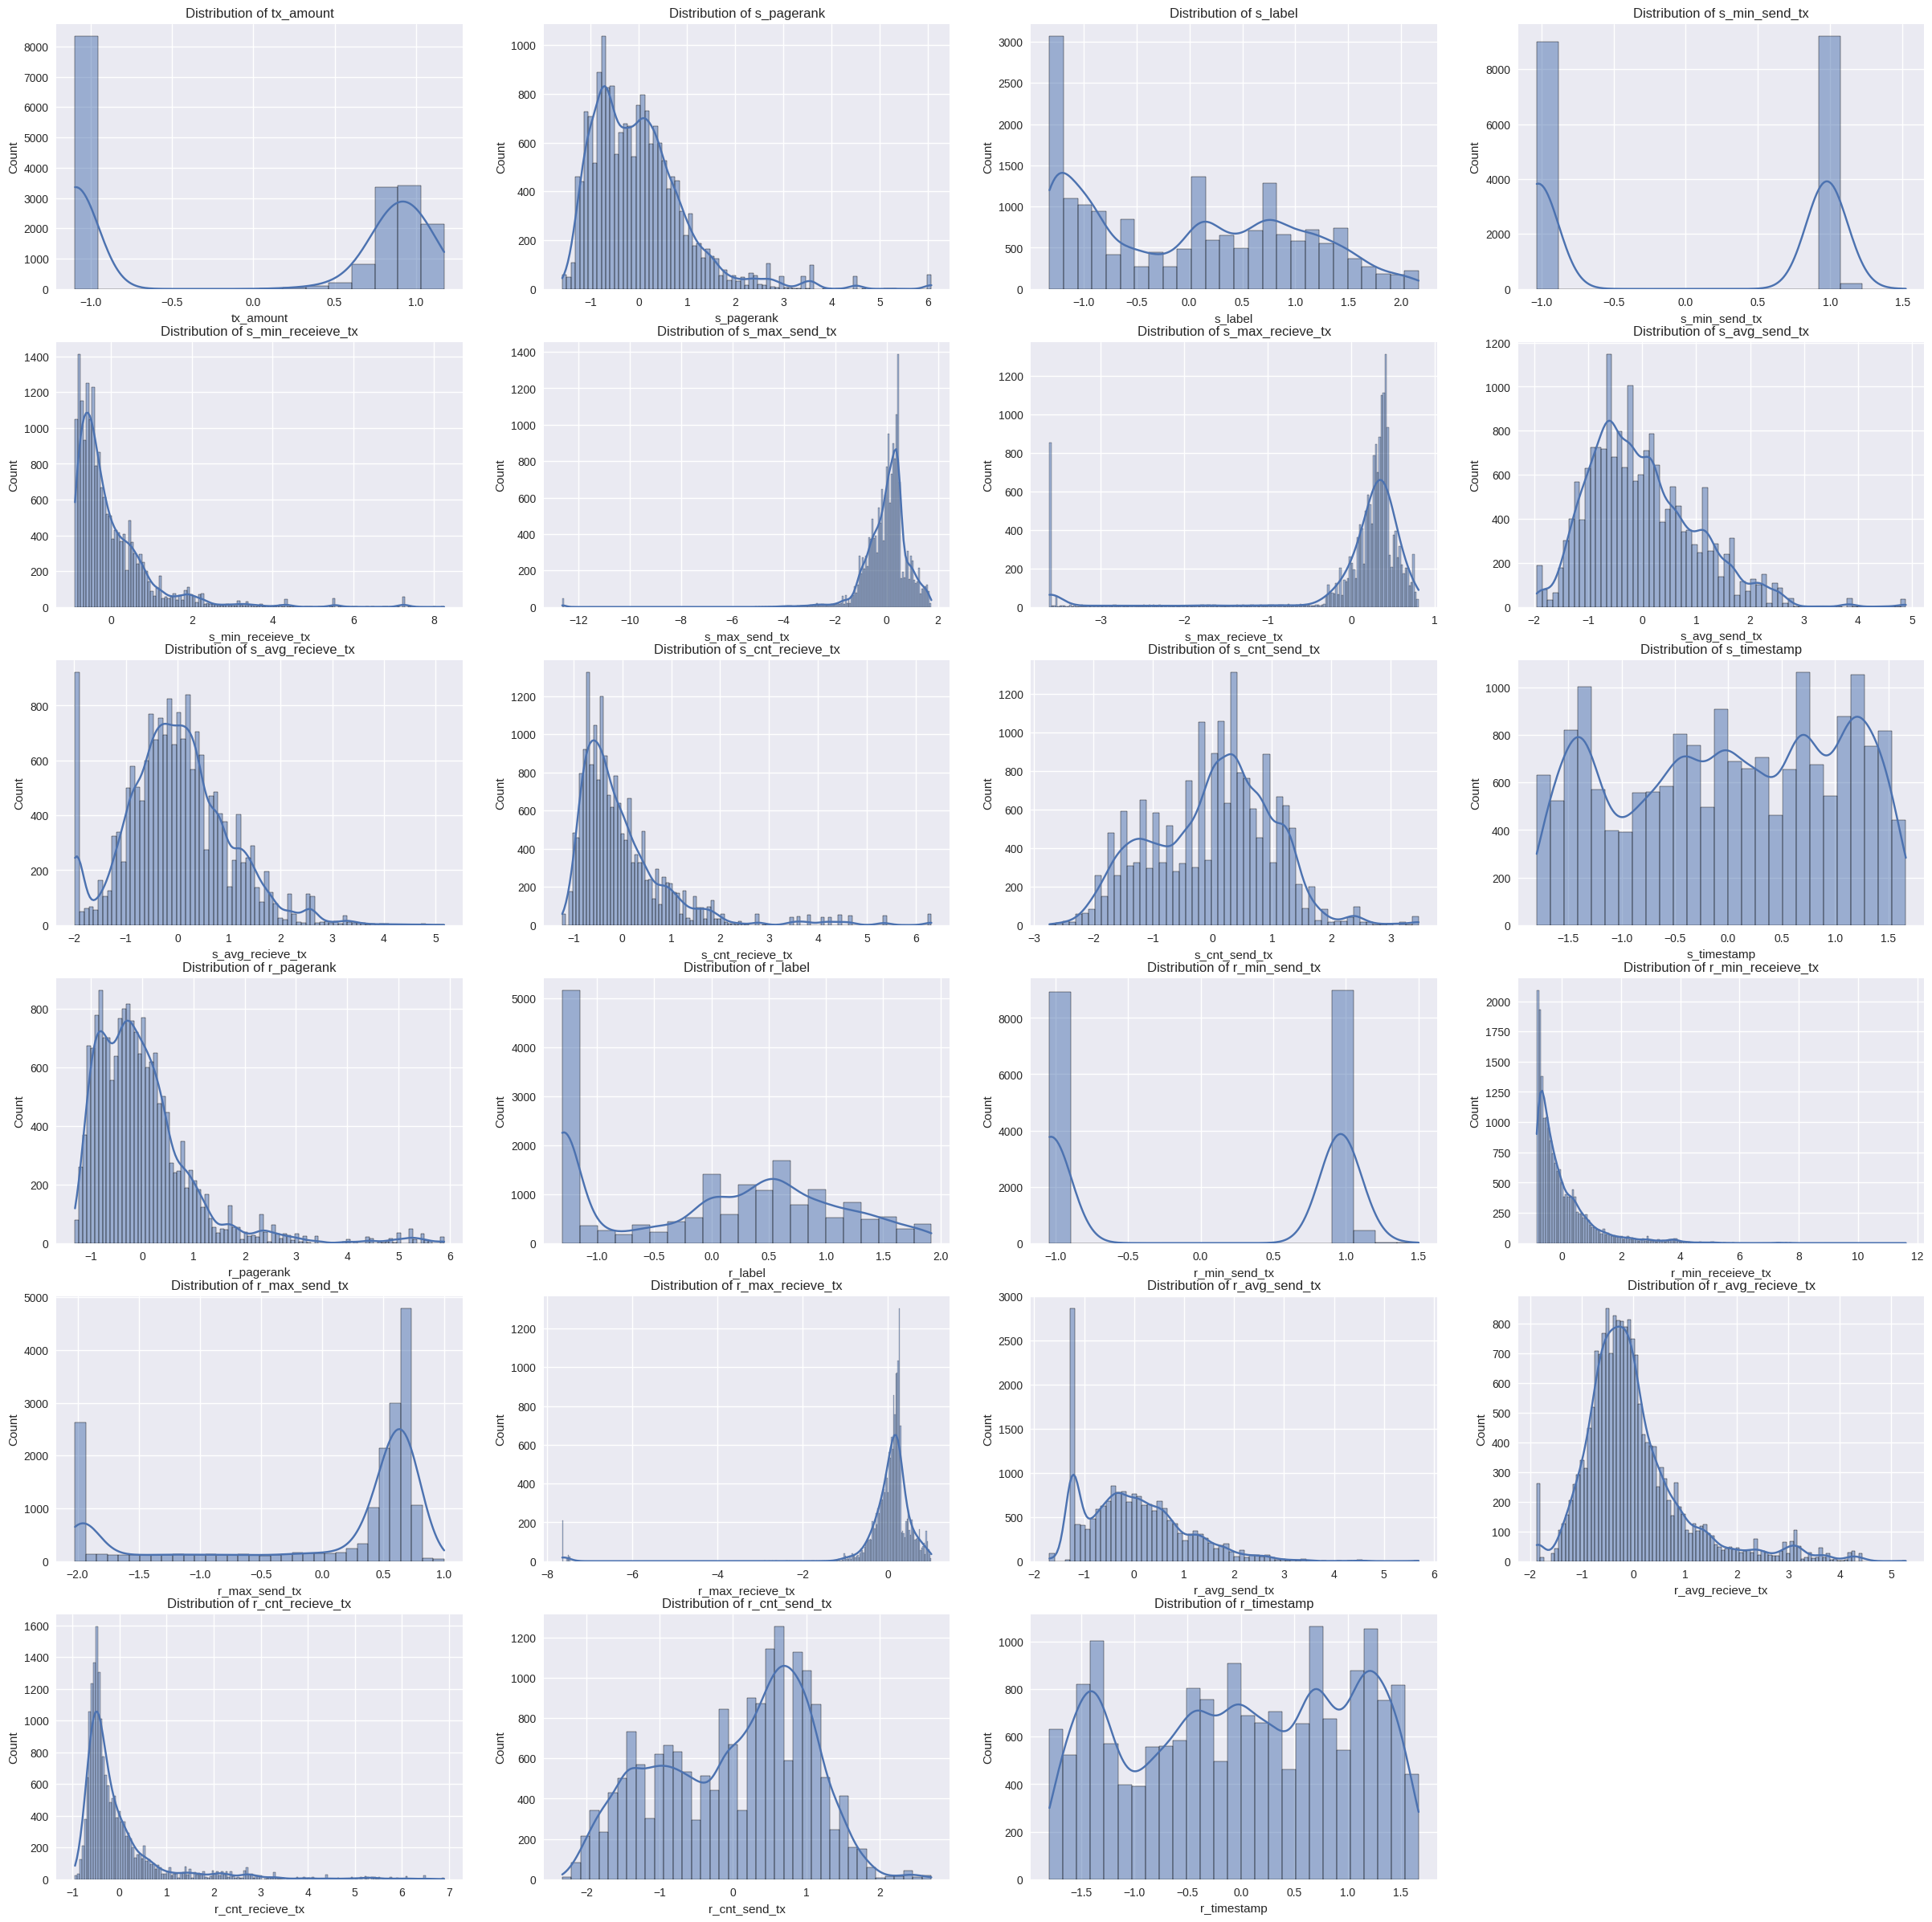

In [22]:
plt.style.use("seaborn")
plt.subplots_adjust(top=0.9,hspace=6,wspace = 3)
plt.figure(figsize=(30,30))
plt.subplot(6,4,1)
i=1
for feature in fraud_data_scaled.columns:
    if feature  in numerical_features :
        plt.subplot(6,4,i)
        sns.histplot(data=fraud_data_scaled, x=feature, kde=True)
        plt.title("Distribution of {}".format(feature))
        i+=1

## XGBoost

Test train split

In [23]:
from sklearn.model_selection import train_test_split

# Initial train-test split
train_fraud, temp_fraud = train_test_split(fraud_resampled_scaled, test_size=0.4, random_state=42, stratify=fraud_resampled_scaled['tx_fraud'])

# Split the remaining 40% into validation and test sets
val_fraud, test_fraud = train_test_split(temp_fraud, test_size=0.5, random_state=42, stratify=temp_fraud['tx_fraud'])

In [24]:
X_train = fraud_resampled_scaled.loc[train_fraud.index, features_to_scale]
y_train = fraud_resampled_scaled.loc[train_fraud.index, 'tx_fraud']

X_val = fraud_resampled_scaled.loc[val_fraud.index, features_to_scale]
y_val = fraud_resampled_scaled.loc[val_fraud.index, 'tx_fraud']

X_test = fraud_resampled_scaled.loc[test_fraud.index, features_to_scale]
y_test = fraud_resampled_scaled.loc[test_fraud.index, 'tx_fraud']




Train

In [35]:
from xgboost import XGBRFClassifier
# Training the XGBoost model
''' xgb_model = XGBRFClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1,
    objective='binary:logistic', max_depth=2, scale_pos_weight=400,
    min_child_weight=80, gamma=10, max_delta_step=2
) '''

xgb_model = XGBRFClassifier(
    n_estimators=10, max_depth=3, learning_rate=0.01, objective='binary:logistic',
    booster='gbtree', gamma=0, min_child_weight=1

)


xgb_model.fit(X_train, y_train, eval_metric='error', eval_set=[(X_train, y_train), (X_val, y_val)])

class_explainer = ClassifierExplainer(xgb_model, X_test, y_test,
                               labels=['Not Fraud', 'Fraud'])
_ = ExplainerDashboard(class_explainer, simple=True).run()

# Measure prediction time for the test set
start_time = time.time()
# Making predictions on the test set using the best XGBoost model
xgb_test_predictions = xgb_model.predict(X_test)
end_time = time.time()
print(f"Time taken for test set prediction: {end_time - start_time:.4f} seconds")
xgb_time= end_time - start_time

# Evaluate the XGBoost model using Precision on the test set
xgb_test_precision = precision_score(y_test, xgb_test_predictions)
print(f"XGBoost Test Precision: {xgb_test_precision}")

# Making predictions on the validation set using XGBoost
xgb_val_predictions = xgb_model.predict(X_val)

# Evaluate the XGBoost model using Precision on validation set
xgb_val_precision = precision_score(y_val, xgb_val_predictions)
print(f"XGBoost Validation Precision: {xgb_val_precision}")

[0]	validation_0-error:0.00000
Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/usr/local/lib/python3.10/dist-packages/dash/dash.py:525: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



  0%|          | 0/3003 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Confusion Matrix:
[[1840    0]
 [   0 1840]]


Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1840
        True       1.00      1.00      1.00      1840

    accuracy                           1.00      3680
   macro avg       1.00      1.00      1.00      3680
weighted avg       1.00      1.00      1.00      3680



Accuracy: 1.0


Precision: 1.0
Recall: 1.0
f1 score: 1.0
1.0


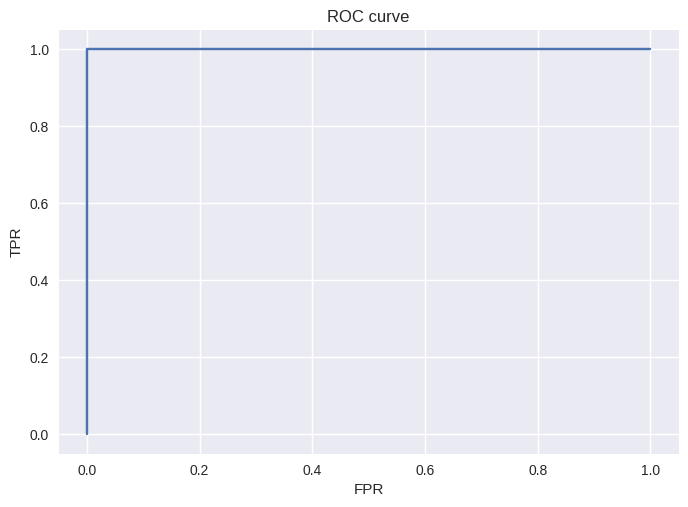

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
x_result = confusion_matrix(y_test, xgb_test_predictions)
print("Confusion Matrix:")
print(x_result)
print('\n')
result1 = classification_report(y_test, xgb_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
x_result2 = accuracy_score(y_test,xgb_test_predictions)
print("Accuracy:",x_result2)
print('\n')
# calculate precision and recall scores
x_precision = precision_score(y_test, xgb_test_predictions)
x_recall = recall_score(y_test, xgb_test_predictions)
x_f1score = f1_score(y_test, xgb_test_predictions)

# print the results
print("Precision:", x_precision)
print("Recall:", x_recall)
print("f1 score:", x_f1score)

print(roc_auc_score(y_test, xgb_test_predictions))

fpr, tpr, _ = roc_curve(y_test, xgb_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [ ]:
''' from xgboost import plot_importance, to_graphviz
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(xgb_model, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);
to_graphviz(xgb_model) '''

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Training the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fitting the model on the training set
knn_model.fit(X_train, y_train)

# Measure prediction time for the test set
start_time = time.time()
# Making predictions on the test set using the best KNN model
knn_test_predictions = knn_model.predict(X_test)
end_time = time.time()
print(f"Time taken for test set prediction: {end_time - start_time:.4f} seconds")
knn_time= end_time - start_time

# Evaluate the KNN model using Precision on the test set
knn_test_precision = precision_score(y_test, knn_test_predictions)
print(f"KNN Test precision: {knn_test_precision}")

# Making predictions on the validation set using KNN
knn_val_predictions = knn_model.predict(X_val)

# Evaluate the KNN model using Precision on the validation set
knn_val_precision = precision_score(y_val, knn_val_predictions)
print(f"KNN Validation precision: {knn_val_precision}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
k_result = confusion_matrix(y_test, knn_test_predictions)
print("Confusion Matrix:")
print(k_result)
print('\n')
result1 = classification_report(y_test, knn_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
k_result2 = accuracy_score(y_test,knn_test_predictions)
print("Accuracy:",k_result2)
print('\n')
# calculate precision and recall scores
k_precision = precision_score(y_test, knn_test_predictions)
k_recall = recall_score(y_test, knn_test_predictions)
k_f1score = f1_score(y_test, knn_test_predictions)

# print the results
print("Precision:", k_precision)
print("Recall:", k_recall)
print("f1 score:", k_f1score)

print(roc_auc_score(y_test, knn_test_predictions))

fpr, tpr, _ = roc_curve(y_test, knn_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

##Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(
    criterion='entropy', max_depth=5, min_samples_split=2,
    min_samples_leaf=1, random_state=42
)

# Training the Decision Tree model
dt_model.fit(X_train, y_train)

# Making predictions on the validation set using the Decision Tree model
dt_val_predictions = dt_model.predict(X_val)

# Evaluate the Decision Tree model using Precision on the validation set
dt_val_precision = precision_score(y_val, dt_val_predictions)
print(f"Decision Tree Validation precision: {dt_val_precision}")


# Measure prediction time for the test set
start_time = time.time()
# Making predictions on the test set using the best Decision Tree model
dt_test_predictions = dt_model.predict(X_test)
end_time = time.time()
print(f"Time taken for test set prediction: {end_time - start_time:.4f} seconds")
dt_time= end_time - start_time

# Evaluate the Decision Tree model using Precision on the test set
dt_test_precision = precision_score(y_test, dt_test_predictions)
print(f"Decision Tree Test precision: {dt_test_precision}")


Note: model_output=='probability', so assuming that raw shap output of DecisionTreeClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Calculating shap values...
Generating layout...
Calculating confusion matrices...
Calculating prediction probabilities...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:525: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Calculating roc auc curves...
Calculating dependencies...
Calculating predictions...
Calculating metrics...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


TypeError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
dt_result = confusion_matrix(y_test, dt_test_predictions)
print("Confusion Matrix:")
print(dt_result)
print('\n')
result1 = classification_report(y_test, dt_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
d_result2 = accuracy_score(y_test,dt_test_predictions)
print("Accuracy:",d_result2)
print('\n')
# calculate precision and recall scores
d_precision = precision_score(y_test, dt_test_predictions)
d_recall = recall_score(y_test, dt_test_predictions)
d_f1score = f1_score(y_test, dt_test_predictions)


# print the results
print("Precision:", d_precision)
print("Recall:", d_recall)
print("f1 score:", d_f1score)

print("ROC AUC Score",roc_auc_score(y_test, dt_test_predictions))

fpr, tpr, _ = roc_curve(y_test, dt_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Random Forest


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting the model on the training set
rf_model.fit(X_train, y_train)

# Measure prediction time for the test set
start_time = time.time()
# Making predictions on the test set using the best Random Forest model
rf_test_predictions = rf_model.predict(X_test)
end_time = time.time()
print(f"Time taken for test set prediction: {end_time - start_time:.4f} seconds")
rf_time= end_time - start_time

# Evaluate the Random Forest model using Precision on the test set
rf_test_precision = precision_score(y_test, rf_test_predictions)
print(f"Random Forest Test precision: {rf_test_precision}")

# Making predictions on the validation set using Random Forest
rf_val_predictions = rf_model.predict(X_val)

# Evaluate the Random Forest model using Precision on the validation set
rf_val_precision = precision_score(y_val, rf_val_predictions)
print(f"Random Forest Validation precision: {rf_val_precision}")



Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:525: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Generating layout...
Calculating confusion matrices...
Calculating prediction probabilities...
Calculating roc auc curves...
Calculating dependencies...
Calculating predictions...
Calculating metrics...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


TypeError: ignored

In [ ]:
rf_result = confusion_matrix(y_test, rf_test_predictions)
print("Confusion Matrix:")
print(rf_result)
print('\n')
result1 = classification_report(y_test, rf_test_predictions)
print("Classification Report:",)
print(result1)
print('\n')
rf_result2 = accuracy_score(y_test, rf_test_predictions)
print("Accuracy:", rf_result2)
print('\n')

# Calculate precision, recall, and F1-score
rf_precision = precision_score(y_test, rf_test_predictions)
rf_recall = recall_score(y_test, rf_test_predictions)
rf_f1score = f1_score(y_test, rf_test_predictions)

# Print the results
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("f1 score:", rf_f1score)
print(roc_auc_score(y_test, rf_test_predictions))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_test_predictions)
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## GNN


Model building

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
class GNNModel(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 32)  # Increased from 16 to 32
        self.conv2 = GCNConv(32, 16)  # New layer
        self.conv3 = GCNConv(16, 2)  # Output layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # New layer
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


Test train split

In [ ]:
from sklearn.model_selection import train_test_split

# Initial train-test split
train_fraud, temp_fraud = train_test_split(fraud_resampled_scaled, test_size=0.4, random_state=42, stratify=fraud_resampled_scaled['tx_fraud'])

# Split the remaining 40% into validation and test sets
val_fraud, test_fraud = train_test_split(temp_fraud, test_size=0.5, random_state=42, stratify=temp_fraud['tx_fraud'])

# Initialize masks
train_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)
val_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)
test_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)

# Update masks based on the indices of the train, validation and test sets
train_mask[train_fraud.index] = True
val_mask[val_fraud.index] = True
test_mask[test_fraud.index] = True

# Update your data object
data_scaled.train_mask = train_mask
data_scaled.val_mask = val_mask
data_scaled.test_mask = test_mask
data_scaled.y = torch.tensor(fraud_resampled_scaled['tx_fraud'].values, dtype=torch.long)

Training

In [ ]:
# Number of node features
num_node_features = x_scaled.shape[1]

In [ ]:
# Initialize the model and optimizer
GN_model = GNNModel(data_scaled.num_node_features)
optimizer = torch.optim.Adam(GN_model.parameters(), lr=0.01)

# Lists to hold loss and precision values for plotting or analysis
train_losses = []
val_losses = []
train_precisions = []
val_precisions = []

# Training loop with validation
for epoch in range(200):
    GN_model.train()
    optimizer.zero_grad()
    out = GN_model(data_scaled)

    # Training loss
    train_loss = F.nll_loss(out[data_scaled.train_mask], data_scaled.y[data_scaled.train_mask])
    train_loss.backward()
    optimizer.step()

    # Calculate training precision
    _, train_pred = out[data_scaled.train_mask].max(dim=1)
    train_true = data_scaled.y[data_scaled.train_mask]
    train_precision = precision_score(train_true.cpu(), train_pred.cpu(), average='micro')

    # Validation
    GN_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Deactivate autograd engine to reduce memory usage and speed up computations
        val_loss = F.nll_loss(out[data_scaled.val_mask], data_scaled.y[data_scaled.val_mask])

        # Calculate validation precision
        _, val_pred = out[data_scaled.val_mask].max(dim=1)
        val_true = data_scaled.y[data_scaled.val_mask]
        val_precision = precision_score(val_true.cpu(), val_pred.cpu(), average='micro')

    # Print the metrics
    print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, Training Precision: {train_precision}, Validation Precision: {val_precision}")

In [ ]:
# Testing and Evaluation
GN_model.eval()
_, pred = out.max(dim=1)
correct = float(pred[data_scaled.test_mask].eq(data_scaled.y[data_scaled.test_mask]).sum().item())
acc = correct / data_scaled.test_mask.sum().item()
print(f"Test Accuracy: {acc}")

from sklearn.metrics import precision_score

# Testing and Evaluation
GN_model.eval()
# Start the timer before making predictions
start_time = time.time()
_, pred = out.max(dim=1)
# Stop the timer after making predictions
end_time = time.time()

print(f"Time taken for testing: {end_time - start_time:.4f} seconds")
g_time= end_time - start_time

# Extract ground truth and predictions for test set
true_labels = data_scaled.y[data_scaled.test_mask].cpu().numpy()
predicted_labels = pred[data_scaled.test_mask].cpu().numpy()

In [ ]:
from sklearn.metrics import f1_score
g_result = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(g_result)
print('\n')
result1 = classification_report(true_labels, predicted_labels)
print("Classification Report:",)
print (result1)
print('\n')
g_result2 = accuracy_score(true_labels,predicted_labels)
print("Accuracy:",g_result2)
print('\n')
# calculate precision and recall scores
g_precision = precision_score(true_labels, predicted_labels)
g_recall = recall_score(true_labels, predicted_labels)
g_f1score = f1_score(true_labels, predicted_labels)

# print the results
print("Precision:", g_precision)
print("Recall:", g_recall)
print("f1 score:", g_f1score)

print(roc_auc_score(true_labels, predicted_labels))

fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their performance metrics
models = ['KNN', 'XGBRFClassifier', 'Decision Tree', 'Random Forest' 'Graph Convolution Network']
accuracy = [k_result2, x_result2, d_result2, rf_result2, g_result2]
precision = [k_precision, x_precision, d_precision, rf_precision, g_precision]
recall = [k_recall, x_recall, d_recall, rf_recall, g_recall]
f1_score = [k_f1score, x_f1score, d_f1score, rf_f1score, g_f1score]

# Create a single plot for all metrics using grouped bar chart
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Model Performance Comparison Across Metrics')

# Set the positions and width for the bars
pos = np.arange(len(models))
bar_width = 0.2

# Plot bars for each metric
rects1 = ax.bar(pos - bar_width*1.5, accuracy, bar_width, label='Accuracy', color='blue')
rects2 = ax.bar(pos - bar_width/2, precision, bar_width, label='Precision', color='green')
rects3 = ax.bar(pos + bar_width/2, recall, bar_width, label='Recall', color='red')
rects4 = ax.bar(pos + bar_width*1.5, f1_score, bar_width, label='F1 Score', color='purple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Metrics Value')
ax.set_xticks(pos)
ax.set_xticklabels(models)
ax.set_ylim([0.7, 1.0])
ax.legend()

# Label with specially formatted floats
ax.bar_label(rects1, fmt='%.3f')
ax.bar_label(rects2, fmt='%.3f')
ax.bar_label(rects3, fmt='%.3f')
ax.bar_label(rects4, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
pip install torchviz

In [ ]:
import torch
from torchviz import make_dot
from IPython.display import Image
import os

# Initialize the model
GN_model = GNNModel(data_scaled.num_node_features)

# Generate dummy output using a sample from your dataset
dummy_output = GN_model(data_scaled)

# Generate the visualization
dot = make_dot(dummy_output, params=dict(GN_model.named_parameters()))

# Save and display
dot.format = 'png'
dot.render(filename='architecture', directory='./', cleanup=True)
display(Image(filename='architecture.png'))


In [ ]:
!pip install hiddenlayer


## Comparisions

In [ ]:
# Define a function to plot the combined ROC curves
def plot_combined_roc(y_test, *models):
    plt.figure(figsize=(10, 8))

    for model_predictions, model_name in models:
        fpr, tpr, _ = roc_curve(y_test, model_predictions)
        plt.plot(fpr, tpr, label=f'{model_name}')

    # Formatting
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal 45 degree line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Combined ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.2)
    plt.show()

# Call the function after predictions for each model are available
plot_combined_roc(y_test,
                  (xgb_test_predictions, "XGBoost"),
                  (knn_test_predictions, "KNN"),
                  (dt_test_predictions, "Decision Tree"),
                  (predicted_labels, "GNN"))  # assuming 'predicted_labels' is the GNN's predictions


time comparision

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their time taken for processing test data
models = ['KNN', 'XGBRFClassifier', 'Decision Tree', 'Random Forest', 'Graph Convolution Network']
times = [knn_time, xgb_time, dt_time, rf_time, g_time]

# Create a single bar plot to compare the time taken by each model
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Model Test Time Comparison')

# Set the positions and width for the bars
pos = np.arange(len(models))
bar_width = 0.5

# Plot bars for the time taken
rects = ax.bar(pos, times, bar_width, color='green')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(pos)
ax.set_xticklabels(models)

# Label with specially formatted floats
ax.bar_label(rects, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their time taken for processing test data
models = ['XGBRFClassifier', 'Decision Tree', 'Random Forest', 'Graph Convolution Network']
times = [xgb_time, dt_time, rf_time, g_time]

# Create a single bar plot to compare the time taken by each model
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Model Test Time Comparison')

# Set the positions and width for the bars
pos = np.arange(len(models))
bar_width = 0.5

# Plot bars for the time taken
rects = ax.bar(pos, times, bar_width, color='green')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(pos)
ax.set_xticklabels(models)

# Label with specially formatted floats
ax.bar_label(rects, fmt='%.3f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
